In [1]:
import pandas as pd 
import numpy as np  
import matplotlib.pyplot as plt 
import seaborn as sns 

sns.set_style('dark')
plt.rcParams['font.family'] = 'Palatino Linotype'

In [8]:
# 训练数据的范围
TRAIN_LEFT = 300000
TRAIN_RIGHT = 340000
# 异常数据所在的范围
L_1 = 449092
R_1 = 449961
L_2 = 521261
R_2 = 521388
L_3 = 529624
R_3 = 530171

intervals = [
    [L_1,R_1],
    [L_2,R_2],
    [L_3,R_3]
]

# Pytorch LSTMAutoEncoder

## 设置随机种子

In [3]:
import torch
import torch.nn as nn 

In [4]:
np.random.seed(1)
torch.manual_seed(2)
SEED = 123

In [5]:
# 数据加载的基类
class Dataset(torch.utils.data.Dataset):
    def __init__(self,x):
        super(Dataset,self).__init__()
        self.x = torch.from_numpy(x).float()
        self.len = x.shape[0]
    def __len__(self):
        # 重载
        return self.len
    def __getitem__(self,idx):
        # 重载
        return self.x[idx]

## 读取数据

In [6]:
data = pd.read_csv('data_8487.csv',index_col=0)

In [7]:
data.head(n=3)

,max_bat_mer_v,min_bat_mer_v,max_temp,min_temp,total_voltage,total_current,soc,mbv0,mbv1,mbv2,...,etpd39,etpd40,etpd41,etpd42,etpd43,etpd44,etpd45,etpd46,etpd47,flag
300000,3.786,3.755,16,14,362.1,-40.0,62,3.769,3.769,3.773,...,15.0,14.0,15.0,15.0,15.0,16.0,16.0,16.0,16.0,0
300001,3.796,3.751,16,14,361.8,11.0,62,3.763,3.763,3.767,...,15.0,14.0,15.0,15.0,15.0,16.0,16.0,16.0,16.0,0
300002,3.769,3.742,16,14,361.0,19.0,62,3.763,3.763,3.766,...,15.0,14.0,15.0,15.0,15.0,16.0,16.0,16.0,16.0,0


## 数据集分割

In [9]:
train_data = data.loc[TRAIN_LEFT:TRAIN_RIGHT]

valid_normal_data = data.loc[TRAIN_RIGHT:TRAIN_RIGHT+5000]
valid_abnormal_data = data.loc[L_1:R_1]

test_normal_data =data.loc[TRAIN_RIGHT+5000:TRAIN_RIGHT+10000]
test_abnormal_data_1 = data.loc[L_2:R_2]
test_abnormal_data_2 = data.loc[L_3:R_3]

## 搭建LSTMAutoEncoder

In [10]:
class LSTMEncoder(nn.Module):
    def __init__(self,fea_size,timestep,batch_size=1):
        super(LSTMEncoder,self).__init__()

        self.fea_size = fea_size # 特征个数
        self.timestep = timestep # 时间步 考虑多少条数据是相关的
        self.batch_size = batch_size # sample数量

        # 第一层 fea_size => 64
        self.lstm1 = nn.LSTM(
            input_size = self.fea_size,
            hidden_size = 64,
            num_layers = 1,
            batch_first = True
        )

        # 第二层 64 => 32
        self.lstm2 = nn.LSTM(
            input_size = 64,
            hidden_size = 32,
            num_layers = 1,
            batch_first = True
        )

        # 第三层 32 => 16
        self.lstm3 = nn.LSTM(
            input_size = 32,
            hidden_size = 16,
            num_layers = 1,
            batch_first = True 
        )
    

    def forward(self,x):
        # encoder input data shape [batch_size,timestep,fea_size]
        # x = x.reshape((self.batch_size,self.timestep,self.fea_size))
        x,_ = self.lstm1(x)
        x,_ = self.lstm2(x)
        # in the last layer of encoder 
        # the output x is discarded
        # only need h_n c_n to init decoder
        x,(h_n,_) = self.lstm3(x) 
        
        # 官方文档中 h_n.shape => (num_layer*num_direction,batch_size,hidden_size)
        return h_n.reshape((self.batch_size,16))

In [11]:
class LSTMDecoder(nn.Module):
    def __init__(self,fea_size,timestep,batch_size=1):
        super(LSTMDecoder,self).__init__()

        self.fea_size = fea_size # 特征个数
        self.timestep = timestep # 时间步 考虑多少条数据是相关的
        self.batch_size = batch_size # sample数量

        # 第一层 16 => 16
        self.lstm1 = nn.LSTM(
            input_size = 16,
            hidden_size = 16,
            num_layers = 1,
            batch_first = True
        )

        # 第二层 16 => 32
        self.lstm2 = nn.LSTM(
            input_size = 16,
            hidden_size = 32,
            num_layers = 1,
            batch_first = True # 保证输入的shape中batch_size为shape[0]
        )

        # 第三层 32 => 64
        self.lstm3 = nn.LSTM(
            input_size = 32,
            hidden_size = 64,
            num_layers = 1,
            batch_first = True
        )

        # 最后接一个全连接 64 => fea_size
        self.output_layer = nn.Linear(64,self.fea_size)
    
    def forward(self,x):    
        # decoder's input shape is encoder's h_n [batch_size,hidden_size]

        x = x.repeat((self.timestep,1)) # 将input增加timestep一个维度 详见pytorch官方文档
        x = x.reshape((self.batch_size,self.timestep,16)) # 将input reshape为[batch_size,timestep,hidden_size]

        x,_ = self.lstm1(x)
        x,_ = self.lstm2(x)
        x,_ = self.lstm3(x)

        x = x.reshape((self.batch_size,self.timestep,64))
        return self.output_layer(x)

In [12]:
class LSTMAutoEncoder(nn.Module):
    def __init__(self,timestep,fea_size,batch_size=1):
        super(LSTMAutoEncoder,self).__init__()
        
        self.encoder = LSTMEncoder(fea_size=fea_size,timestep=timestep,batch_size=batch_size)
        self.decoder = LSTMDecoder(fea_size=fea_size,timestep=timestep,batch_size=batch_size)

    def forward(self,x):
        # encoder's input shape is [batch_size,timestep,fea_size]
        x = self.encoder(x)
        # decoder's input shape is [batch_size,hidden_size]
        x = self.decoder(x)

        return x

## 准备LSTM输入数据

In [13]:
# 将二维数据转换为三维 作为LSTM的输入
def convert3D(x,y,lookback):
    '''
    x.shape => (n_observations,n_features)
    lookback: window_size

    output_x.shape => (n_observatons-1-lookback,lookback,n_features)
    '''
    output_x = []
    output_y = []
    for i in range(0,len(x)-1-lookback): # 0 <= i <= len(x)-1-lookback-1
        t = []
        for j in range(1,lookback+1): # 1 <= j <= lookback
            t.append(x[i+j+1,:])  # 将timestep内的合在一起 2 <= i+j+1 <= len(x)-1
        output_x.append(t)
        output_y.append(y[i+1+lookback])
    return np.array(output_x),np.array(output_y)

In [14]:
LOOKBACK = 50

In [15]:
trans_train,trans_train_flag = convert3D(x=train_data.drop('flag',axis=1).values,y=train_data['flag'].values,lookback=LOOKBACK)

trans_valid_normal,trans_valid_normal_flag = convert3D(x=valid_normal_data.drop('flag',axis=1).values,y=valid_normal_data['flag'].values,lookback=LOOKBACK)
trans_valid_abnormal,trans_valid_abnormal_flag = convert3D(x=valid_abnormal_data.drop('flag',axis=1).values,y=valid_abnormal_data['flag'].values,lookback=LOOKBACK)

trans_test_normal,trans_test_normal_flag = convert3D(x=test_normal_data.drop('flag',axis=1).values,y=test_normal_data['flag'].values,lookback=LOOKBACK)
trans_test_abnormal_1,trans_test_abnormal_flag_1 = convert3D(x=test_abnormal_data_1.drop('flag',axis=1).values,y=test_abnormal_data_1['flag'].values,lookback=LOOKBACK)
trans_test_abnormal_2,trans_test_abnormal_flag_2 = convert3D(x=test_abnormal_data_2.drop('flag',axis=1).values,y=test_abnormal_data_2['flag'].values,lookback=LOOKBACK)

In [16]:
# 将2D转换为3D shape[0]变为shape[0]-lookback-1
print(train_data.shape,trans_train.shape)

print(valid_normal_data.shape,trans_valid_normal.shape)
print(valid_abnormal_data.shape,trans_valid_abnormal.shape)

print(test_normal_data.shape,trans_test_normal.shape)
print(test_abnormal_data_1.shape,trans_test_abnormal_1.shape)
print(test_abnormal_data_2.shape,trans_test_abnormal_2.shape)

(40001, 152) (39950, 50, 151)
(5001, 152) (4950, 50, 151)
(870, 152) (819, 50, 151)
(5001, 152) (4950, 50, 151)
(128, 152) (77, 50, 151)
(548, 152) (497, 50, 151)


## LSTM数据标准化

- 这里``trans_train``是三维数据
- AutoEncoder更适合标准化
- One common standardization mistake is: we normalize the entire data and then split into train-test. This is incorrect. Test data should be completely unseen to anything during the modeling. We should, therefore, normalize the training data, and use its summary statistics to normalize the test data (for normalization, these statistics are the mean and variances of each feature)

In [17]:
def flatten(x):
    '''
    flatten a 3D array

    Input: x => input of lstm x.shape => samples*timesteps*features
    Output: 2D array, shape => samples*features
    '''
    flatten_x = np.empty((x.shape[0],x.shape[2]))
    for i in range(x.shape[0]):
        flatten_x[i] = x[i,(x.shape[1]-1),:]
    return flatten_x

def standardize(x,scaler):
    '''
    standardize 3D array
    '''
    for i in range(x.shape[0]):
        x[i,:,:] = scaler.transform(x[i,:,:])
    return x 

In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(flatten(trans_train)) # initialize a scaler depending on statistics of train data

train_scale = standardize(trans_train,scaler)

valid_normal_scale = standardize(trans_valid_normal,scaler)
valid_abnormal_scale = standardize(trans_valid_abnormal,scaler)

test_normal_scale = standardize(trans_test_normal,scaler)
test_abnormal_1_scale = standardize(trans_test_abnormal_1,scaler)
test_abnormal_2_scale = standardize(trans_test_abnormal_2,scaler)

### 检查标准化的正确性

In [19]:
# 标准化后每列的均值为0 标准差为1
tmp = flatten(train_scale)
print('colwise mean',np.mean(tmp,axis=0).round(6))
print('colwise std', np.std(tmp,axis=0))

colwise mean [-0.  0.  0. -0. -0.  0.  0.  0. -0. -0.  0. -0.  0.  0.  0. -0. -0.  0.
 -0.  0. -0. -0. -0. -0.  0. -0. -0.  0. -0. -0.  0. -0. -0. -0. -0. -0.
  0.  0.  0.  0. -0. -0.  0. -0.  0. -0. -0.  0.  0. -0.  0. -0. -0. -0.
  0.  0. -0.  0. -0. -0. -0.  0.  0. -0. -0.  0. -0. -0. -0.  0. -0.  0.
 -0. -0. -0.  0.  0. -0. -0. -0. -0. -0. -0.  0. -0.  0. -0.  0. -0. -0.
 -0. -0. -0. -0. -0.  0.  0.  0. -0.  0.  0. -0. -0.  0. -0. -0. -0.  0.
  0. -0.  0. -0. -0. -0.  0. -0.  0. -0. -0. -0. -0. -0. -0. -0.  0.  0.
 -0. -0.  0. -0. -0.  0. -0.  0. -0. -0.  0.  0.  0. -0.  0.  0. -0.  0.
 -0.  0.  0. -0.  0. -0. -0.]
colwise std [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

## 训练前准备工作 创建数据loader和赋值超参

In [20]:
# 超参数
TIMESTEP = train_scale.shape[1]
FEATURE_SIZE = train_scale.shape[2]
BATCH_SIZE = 32 # 每批数据的量
LR = 1e-2 # 学习率
MOMENTUM = 0.9 
DECAY = 1e-5 # 权重衰减
EPOCHS = 30 # 训练回合数

In [26]:
from collections import defaultdict
# 使用gpu训练
device = 'cuda' if torch.cuda.is_available() else 'cpu'

metrics = defaultdict(list)

# 加载数据
train_set = Dataset(x=train_scale)
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
    drop_last=True
)

# 创建自编码器工作
model = LSTMAutoEncoder(fea_size=FEATURE_SIZE,timestep=LOOKBACK,batch_size=BATCH_SIZE)
model.to(device)

# 损失函数 MSE
criterion = nn.MSELoss(reduction='mean')
# 优化器 SGD
optimizer = torch.optim.SGD(
    model.parameters(),
    lr = LR,
    weight_decay = DECAY
)

## Training

In [21]:
model.train() # 将model设置为训练状态
for epoch in range(EPOCHS):
    running_loss = 0.0
    for _, data in enumerate(train_loader):
        sample = model(data.to(device)) # 将数据送入模型
        loss = criterion(data.to(device),sample) # 计算误差
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_set)
    if (epoch % 2 == 0):
        print('Epoch:{} Train_Loss:{}'.format(epoch,epoch_loss))
    metrics['train_loss'].append(epoch_loss)

np.savetxt('car_8487_lstmae_train_loss.txt',np.array(metrics['train_loss'])) # 保存模型训练loss
torch.save(model.state_dict(),'car_8487_lstmae.pth') # 保存模型

Epoch:0 Train_Loss:0.031386720136050435
Epoch:2 Train_Loss:0.03129550158380716
Epoch:4 Train_Loss:0.031257530563465495
Epoch:6 Train_Loss:0.031243206144721994
Epoch:8 Train_Loss:0.03123642604177974
Epoch:10 Train_Loss:0.031231546029728257
Epoch:12 Train_Loss:0.031231417805142932
Epoch:14 Train_Loss:0.03123054241059868
Epoch:16 Train_Loss:0.031228978075879685
Epoch:18 Train_Loss:0.031230437808550046
Epoch:20 Train_Loss:0.031229430196879057
Epoch:22 Train_Loss:0.031228746427910795
Epoch:24 Train_Loss:0.03122943513086054
Epoch:26 Train_Loss:0.031232563270645237
Epoch:28 Train_Loss:0.031229230432546183


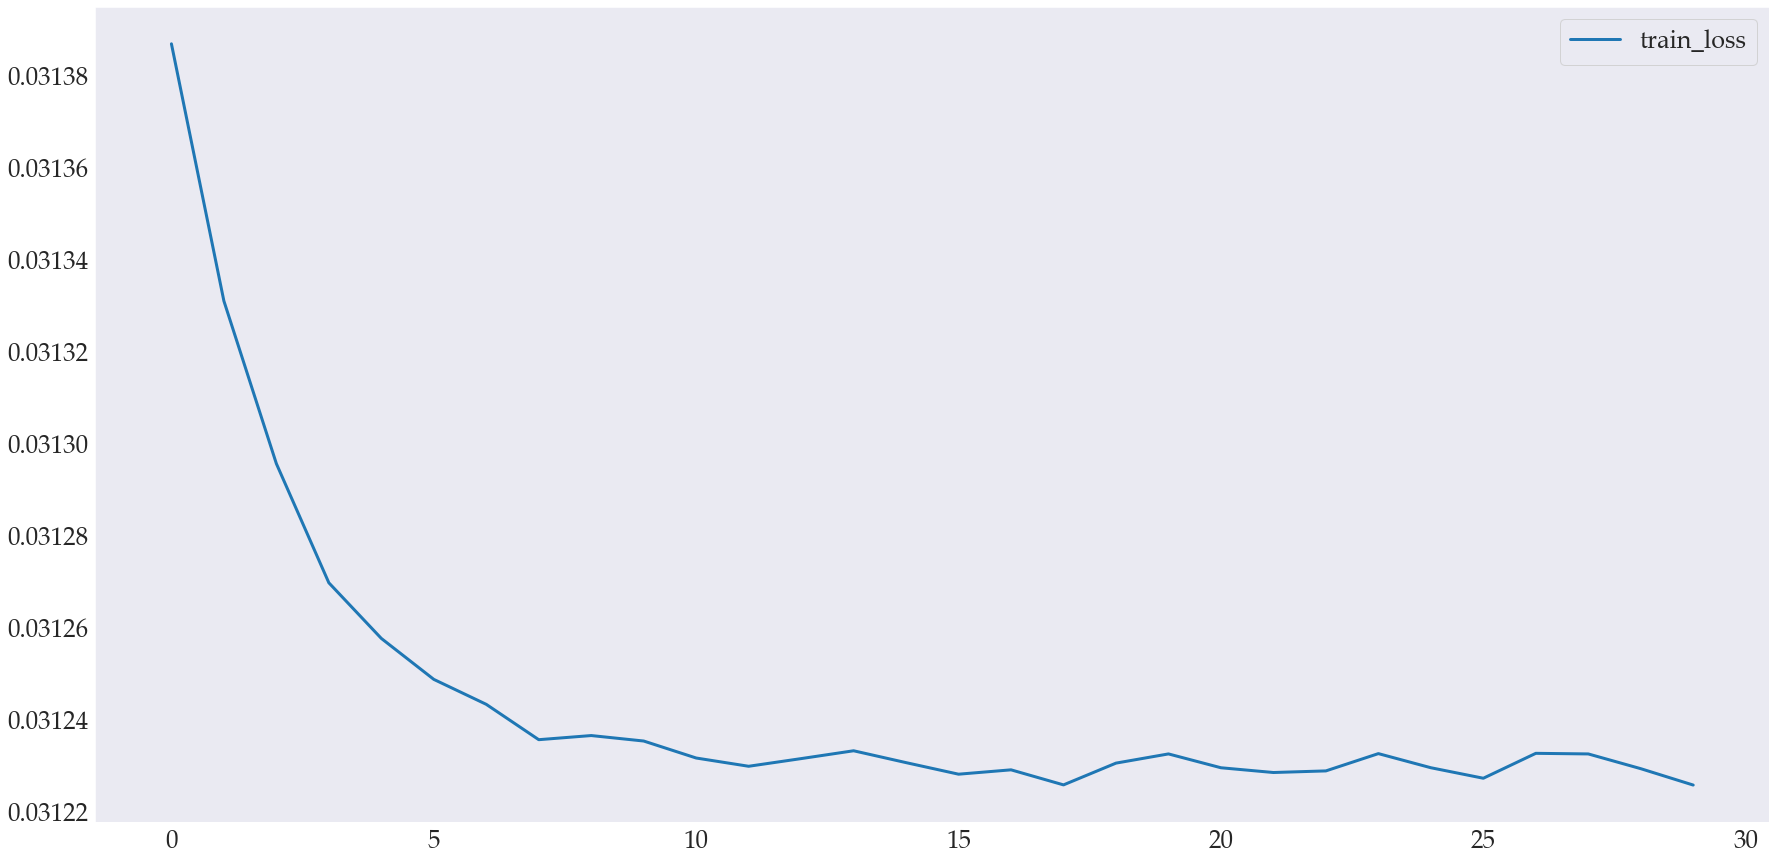

In [22]:
fig = plt.figure(figsize=(30,15))

plt.rc('font',size=20)
plt.ticklabel_format(style='sci')
plt.tick_params(labelsize=25)
plt.plot(metrics['train_loss'],linewidth=3,label='train_loss')
plt.legend(fontsize=25)

plt.show()

## Validation集设置Threshold

In [27]:
from sklearn.metrics import confusion_matrix,precision_recall_curve
from sklearn.metrics import recall_score,classification_report,auc,roc_curve
from sklearn.metrics import precision_recall_fscore_support,f1_score

In [28]:
eval_model = LSTMAutoEncoder(fea_size=FEATURE_SIZE,timestep=TIMESTEP,batch_size=1)
eval_model.load_state_dict(torch.load('car_8487_lstmae.pth'))
eval_model.to(device)
eval_model.eval() # 将模型调至evaluation模式

valid_set_1 = Dataset(x=valid_normal_scale)
valid_loader_1 = torch.utils.data.DataLoader(
    valid_set_1,
    batch_size=1,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
    drop_last=True
)

valid_set_2 = Dataset(x=valid_abnormal_scale)
valid_loader_2 = torch.utils.data.DataLoader(
    valid_set_2,
    batch_size=1,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
    drop_last=True
)

metrics['validation_loss'] = []
for _, data in enumerate(valid_loader_1):
    sample = eval_model(data.to(device)) # 将数据送入模型
    loss = criterion(data.to(device),sample) # 计算误差
    metrics['validation_loss'].append(loss.item())

for _, data in enumerate(valid_loader_2):
    sample = eval_model(data.to(device)) # 将数据送入模型
    loss = criterion(data.to(device),sample) # 计算误差
    metrics['validation_loss'].append(loss.item())

np.savetxt('car_8487_lstmae_validation_loss.txt',np.array(metrics['validation_loss'])) # 保存模型训练loss

In [38]:
loss_df = pd.DataFrame({'rebuilt_loss':metrics['validation_loss'],'flag':np.concatenate((trans_valid_normal_flag,trans_valid_abnormal_flag))})

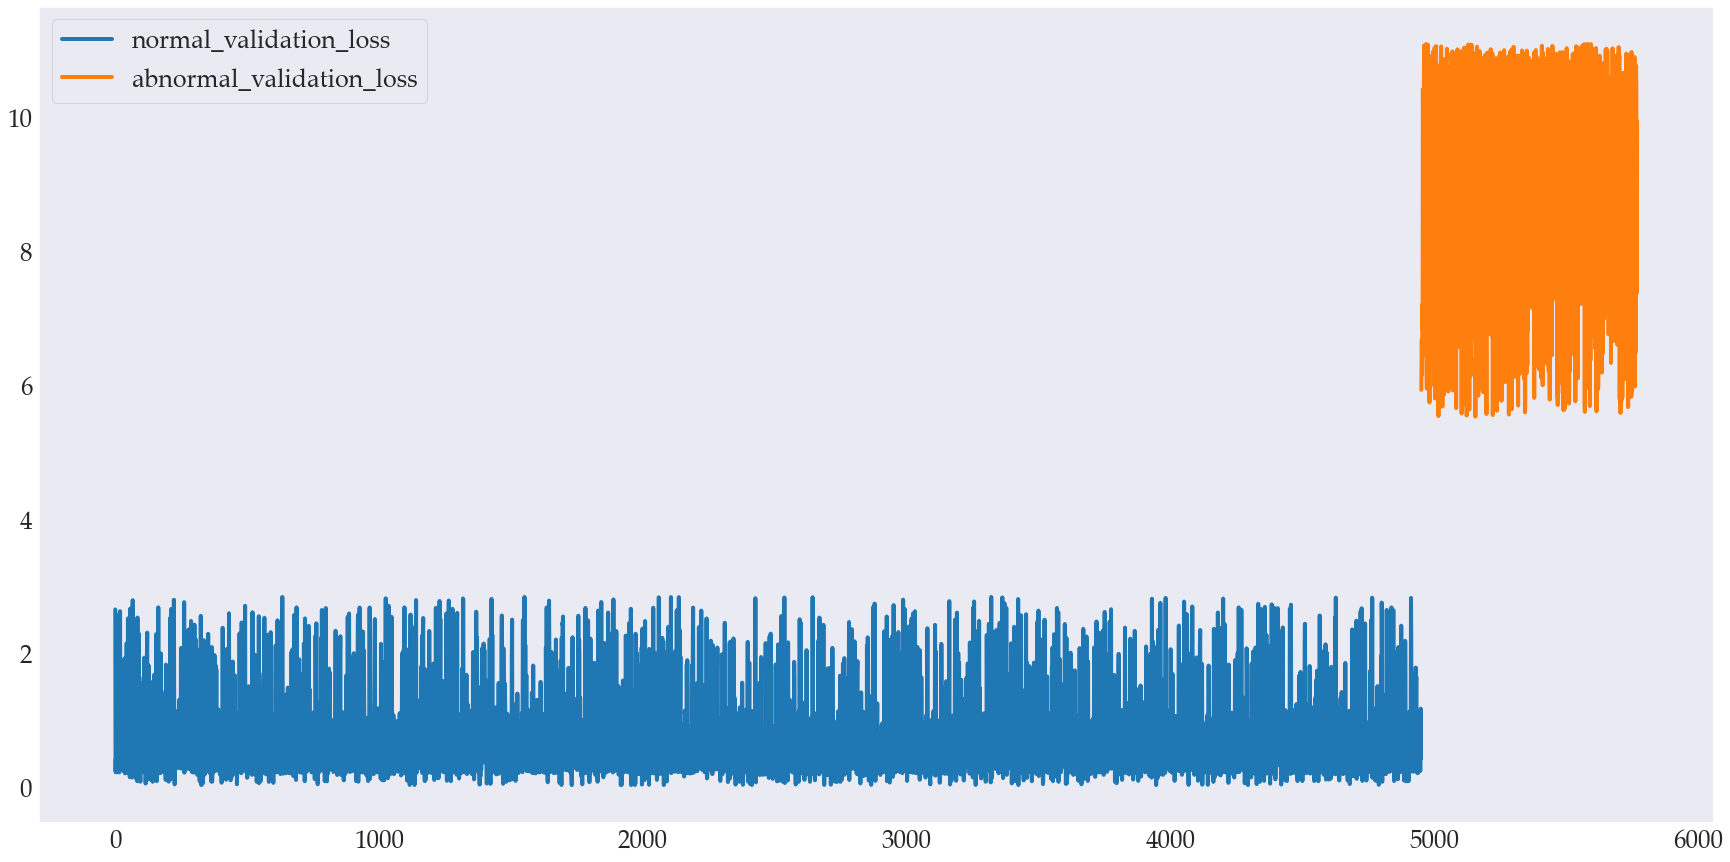

In [40]:
tmp_df = loss_df.reset_index()

fig = plt.figure(figsize=(30,15))
plt.rc('font',size=25)
plt.plot(tmp_df[tmp_df['flag']==0]['rebuilt_loss'],label='normal_validation_loss',linewidth=4)
plt.plot(tmp_df[tmp_df['flag']==1]['rebuilt_loss'],label='abnormal_validation_loss',linewidth=4)
plt.legend()
plt.show()

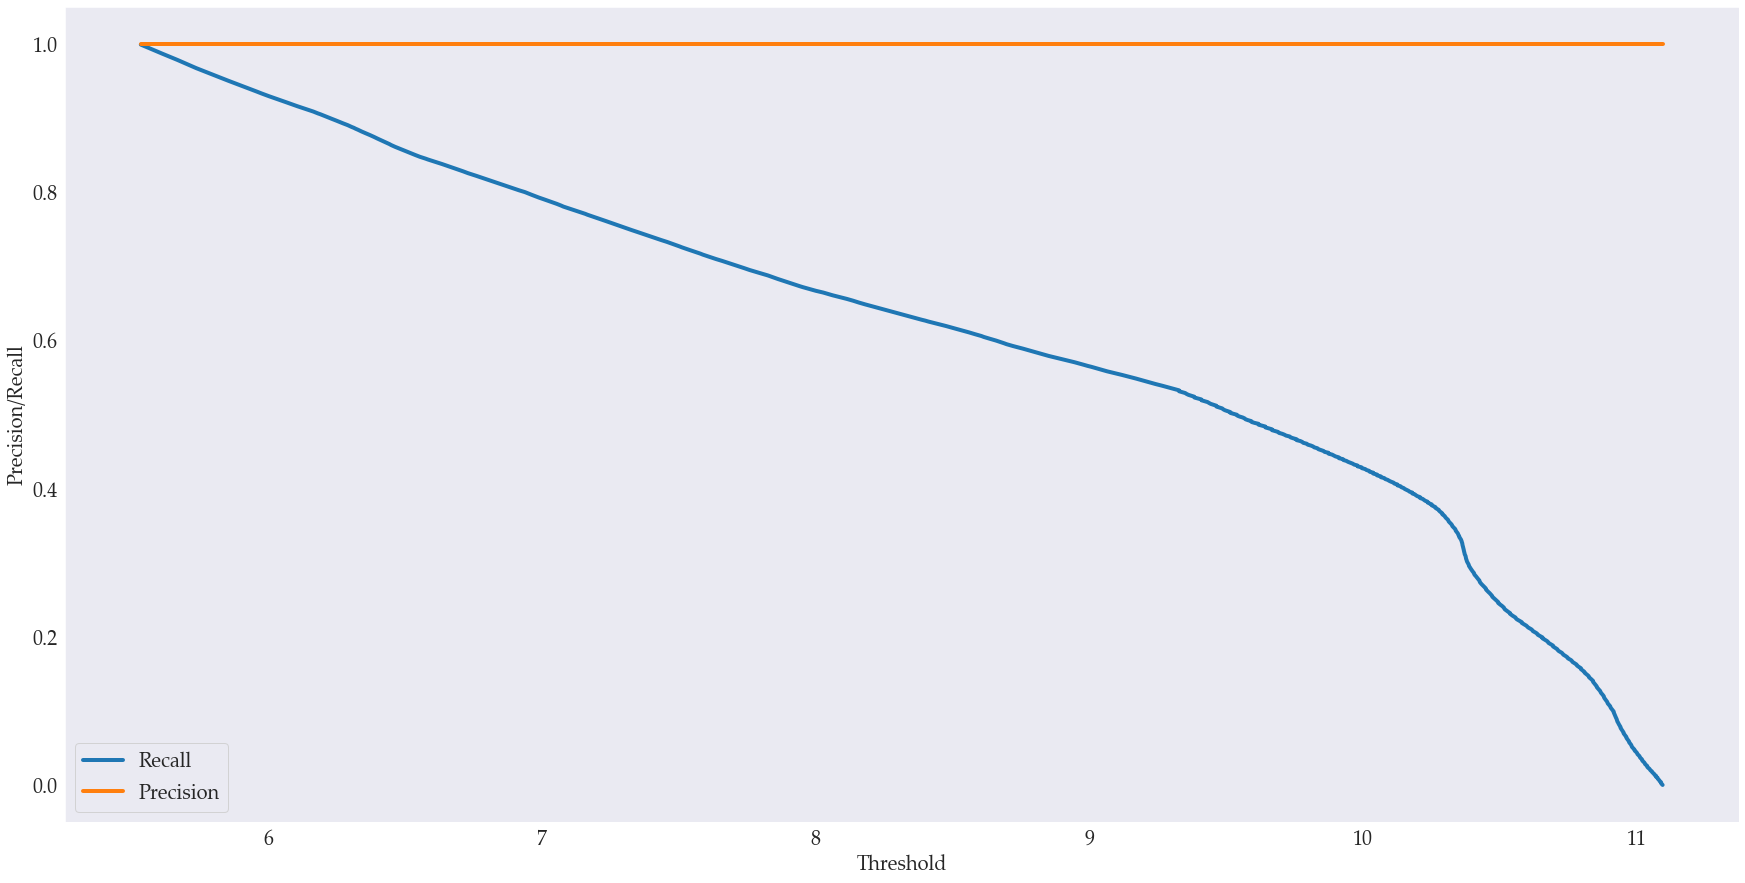

In [41]:
precision_rt,recall_rt,threshold_rt = precision_recall_curve(loss_df.flag,loss_df.rebuilt_loss)

fig = plt.figure(figsize=(30,15))
plt.rc('font',size=20)
plt.plot(threshold_rt,recall_rt[1:],label='Recall',linewidth=4)
plt.plot(threshold_rt,precision_rt[1:],label='Precision',linewidth=4)
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()

plt.show()

## 测试集测试模型的性能

In [42]:
test_set_1 = Dataset(x=test_normal_scale)
test_loader_1 = torch.utils.data.DataLoader(
    test_set_1,
    batch_size=1,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
    drop_last=True
)

test_set_2 = Dataset(x=test_abnormal_1_scale)
test_loader_2 = torch.utils.data.DataLoader(
    test_set_2,
    batch_size=1,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
    drop_last=True
)

test_set_3 = Dataset(x=test_abnormal_2_scale)
test_loader_3 = torch.utils.data.DataLoader(
    test_set_3,
    batch_size=1,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
    drop_last=True
)

metrics['test_loss'] = []
for _, data in enumerate(test_loader_1):
    sample = eval_model(data.to(device)) # 将数据送入模型
    loss = criterion(data.to(device),sample) # 计算误差
    metrics['test_loss'].append(loss.item())

for _, data in enumerate(test_loader_2):
    sample = eval_model(data.to(device)) # 将数据送入模型
    loss = criterion(data.to(device),sample) # 计算误差
    metrics['test_loss'].append(loss.item())

for _, data in enumerate(test_loader_3):
    sample = eval_model(data.to(device)) # 将数据送入模型
    loss = criterion(data.to(device),sample) # 计算误差
    metrics['test_loss'].append(loss.item())

np.savetxt('car_8487_lstmae_test_loss.txt',np.array(metrics['test_loss'])) # 保存模型训练loss

<Figure size 2160x1080 with 0 Axes>

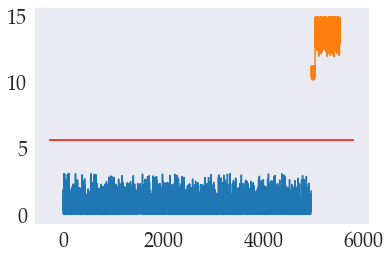

In [44]:
THRESHOLD = 5.6

tmp_flag = np.concatenate((trans_test_normal_flag,trans_test_abnormal_flag_1))
tmp_flag = np.concatenate((tmp_flag,trans_test_abnormal_flag_2))
test_loss_df = pd.DataFrame({'rebuilt_loss':metrics['test_loss'],'flag':tmp_flag})
tmp_df = test_loss_df.reset_index()

groups = tmp_df.groupby('flag')

plt.figure(figsize=(30,15))
fig,ax = plt.subplots()
plt.rc('font',size=20)
for name,group in groups:
    ax.plot(group.index,group.rebuilt_loss,label='Abnormal' if name==1 else 'Normal')
ax.hlines(THRESHOLD,ax.get_xlim()[0],ax.get_xlim()[1],colors='r',label='Threshold')

plt.show()